In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pyflux as pf
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as sm
import scipy.stats as sp
from sklearn.metrics import mean_squared_error as rmse

In [2]:
msft = pd.DataFrame.from_csv('MSFT.csv')
msft = msft.interpolate()
#changing the index to go from 1986 to 2016
msft = msft.reindex(index=msft.index[::-1])
investor = pd.DataFrame.from_csv('investor.csv')
investor = investor.fillna(investor.mean())
#changing the index to go from 1987 to 2016
investor = investor.reindex(index=investor.index[::-1])

In [3]:
def evaluateModel(prediction,actual):    
    prediction.plot(color='red', label='Prediction')
    actual.plot(color='blue', label='Actual')
    plt.legend(loc='best')
    prediction = np.array(prediction.tolist())
    actual = np.array(actual.tolist())
    print('Pearson Correlation Coeefiecient: ', sp.pearsonr(actual, prediction))
    error2 = [((x-y)/y)**2 for x, y in zip(prediction, actual)]
    print ("Normalised RMSE",np.sqrt(np.sum(error2)))

In [4]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determining Rolling Statistics
    
    rolmean=timeseries.rolling(window=12,center=False).mean()
    rolstd=timeseries.rolling(window=12,center=False).std()
    
    #Plot Rolling Statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dicket Fuller Test:'
    dftest=adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print dfoutput

In [5]:
pre2006 = msft.loc['1987':'2005']
pre2006 = pre2006.interpolate()
trainTS = pre2006.Open

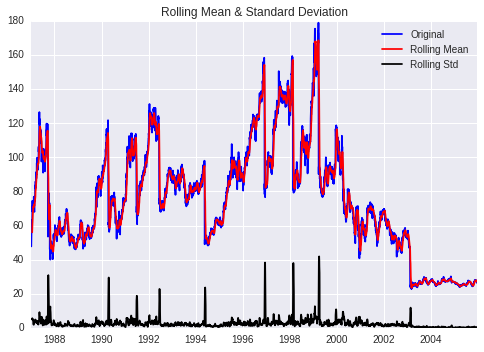

Results of Dicket Fuller Test:
Test Statistic                   -3.153441
p-value                           0.022843
#Lags Used                        2.000000
Number of Observations Used    4791.000000
Critical Value (5%)              -2.862143
Critical Value (1%)              -3.431716
Critical Value (10%)             -2.567091
dtype: float64


In [6]:
test_stationarity(trainTS)

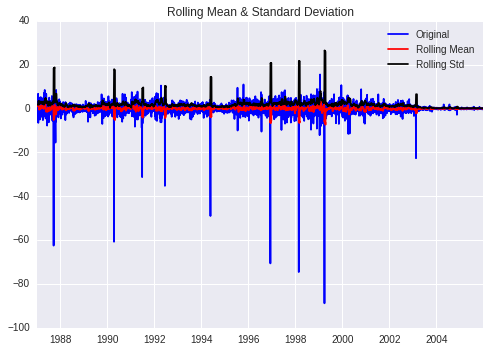

Results of Dicket Fuller Test:
Test Statistic                  -51.213613
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    4791.000000
Critical Value (5%)              -2.862143
Critical Value (1%)              -3.431716
Critical Value (10%)             -2.567091
dtype: float64


In [7]:
DiffTrainTS = trainTS - trainTS.shift()
DiffTrainTS = DiffTrainTS[1:]
test_stationarity(DiffTrainTS)

test statistic is lower than the critical values so this time series is stationary

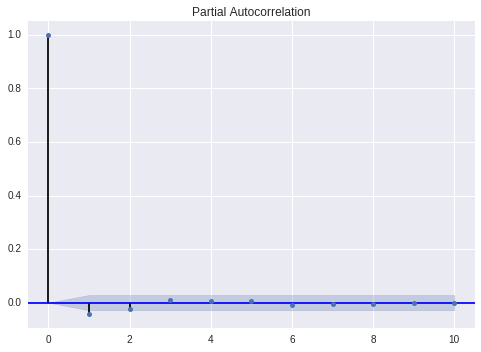

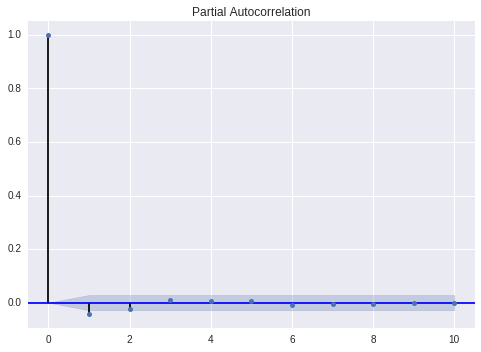

In [8]:
##determines AR order
smt.graphics.plot_pacf(DiffTrainTS, lags=10)

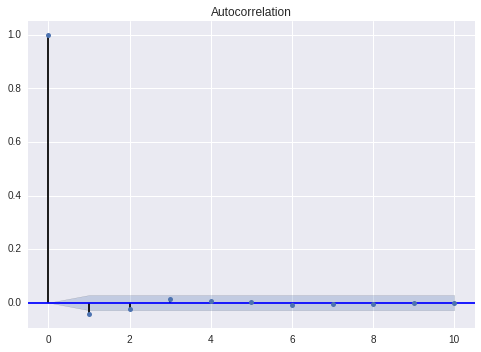

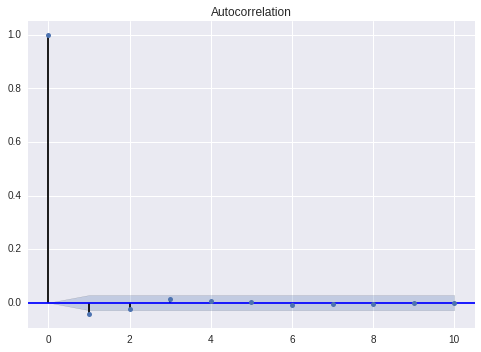

In [9]:
##determines MA order
smt.graphics.plot_acf(DiffTrainTS,  lags=10)

In [10]:
arimapf=pf.ARIMA(pre2006, ar=1, ma=1, integ=1,target='Open')
fit=arimapf.fit()
fit.summary()

ARIMA(1,1,1)                                                                                              
======================================================= ==================================================
Dependent Variable: Differenced Open                    Method: MLE                                       
Start Date: 1987-01-05 00:00:00                         Log Likelihood: -12422.4031                       
End Date: 2005-12-30 00:00:00                           AIC: 24852.8063                                   
Number of observations: 4792                            BIC: 24878.7051                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0034    0.0326     -0.1035  0.9175   (-0.0672 | 0.0604)       
AR(1)                                

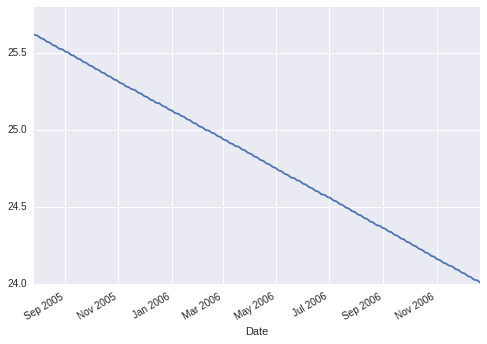

In [11]:
predictionDiff= arimapf.predict(h=356)['Differenced Open']
prediction_cumsum=predictionDiff.cumsum()
prediction = pd.Series(trainTS.loc[predictionDiff.index[0]], index=predictionDiff.index)
prediction = prediction.add(prediction_cumsum,fill_value=0)
prediction.plot()

In [12]:
testOutput = msft.loc[prediction.index].Open
testOutput = testOutput.interpolate()

('Pearson Correlation Coeefiecient: ', (-0.10597134634674915, 0.045710076142089759))
('Normalised RMSE', 1.7066501124894551)


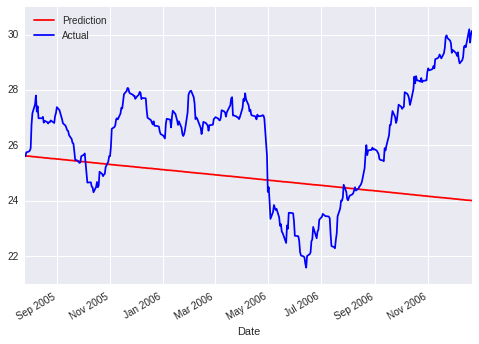

In [13]:
evaluateModel(prediction, testOutput)